In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np 

In [46]:
#Load MNIST data

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.1337,], [0.3086,])]) #?

trainset = torchvision.datasets.MNIST("", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST("", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


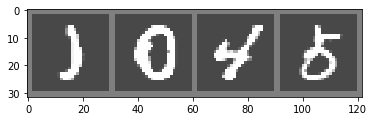

    1     0     4     5


In [47]:
# Data visualization

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(4)))

In [48]:
## Construct the neural network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()

In [49]:
## Train

LOAD_MODEL=True #Load a pre-trained model if it exists. Set to False to re-train the model

def train():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(1):
        print(f"Epoch {epoch}")
        running_loss = 0.0
        
        for i, data in tqdm(enumerate(trainloader)):
            images, labels = data
            #Forward Pass
            outputs = net(images)
            #Calculating loss
            loss = criterion(outputs, labels)
            #Backward pass & update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print("Finished training")

    
PATH = 'cnn_mnist.pth'
if LOAD_MODEL:
    try:
        net.load_state_dict(torch.load(PATH))
    except Exception:
        train()
        torch.save(net.state_dict(), PATH)
else:
    train()
    torch.save(net.state_dict(), PATH)

Epoch 0


[1,  2000] loss: 1.096
[1,  4000] loss: 0.529
[1,  6000] loss: 0.425
[1,  8000] loss: 0.375
[1, 10000] loss: 0.336
[1, 12000] loss: 0.339
[1, 14000] loss: 0.306

Finished training


In [50]:
## Test

def test():   
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy: %d %%' % (
        100 * correct / total))

test()


Accuracy: 92 %
